In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler 

import squarify

In [2]:
rfm_df= pd.read_csv('rfm_df.csv')
rfm_df.head(3)

,Unnamed: 0,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,1388,2433,3,7,375.31,4,4,4,444,12,Best Customers
1,1159,2193,91,11,361.45,3,4,4,344,11,Big Spenders
2,772,1793,26,10,345.10,4,4,4,444,12,Best Customers


In [3]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     3898 non-null   int64  
 1   Member_number  3898 non-null   int64  
 2   Recency        3898 non-null   int64  
 3   Frequency      3898 non-null   int64  
 4   Monetary       3898 non-null   float64
 5   R              3898 non-null   int64  
 6   F              3898 non-null   int64  
 7   M              3898 non-null   int64  
 8   RFM_Segment    3898 non-null   int64  
 9   RFM_Score      3898 non-null   int64  
 10  RFM_Level      3898 non-null   object 
dtypes: float64(1), int64(9), object(1)
memory usage: 335.1+ KB


## RFM + KMeans

In [4]:
df_now = rfm_df[['Recency','Frequency','Monetary']]
df_now.head()

,Recency,Frequency,Monetary
0,3,7,375.31
1,91,11,361.45
2,26,10,345.10
3,4,10,334.15
4,142,7,312.46


In [5]:
rfm_df['Log_Recency'] = np.log1p(rfm_df['Recency'])
rfm_df['Log_Frequency'] = np.log1p(rfm_df['Frequency'])
rfm_df['Log_Monetary'] = np.log1p(rfm_df['Monetary'])

scaler = RobustScaler()
rfm_df[['Scaled_Log_Recency', 'Scaled_Log_Frequency', 'Scaled_Log_Monetary']] = scaler.fit_transform(rfm_df[['Log_Recency', 'Log_Frequency', 'Log_Monetary']])

In [6]:
print(rfm_df.head())

   Unnamed: 0  Member_number  Recency  Frequency  Monetary  R  F  M  \
0        1388           2433        3          7    375.31  4  4  4   
1        1159           2193       91         11    361.45  3  4  4   
2         772           1793       26         10    345.10  4  4  4   
3        2225           3289        4         10    334.15  4  4  4   
4        1692           2743      142          7    312.46  2  4  4   

   RFM_Segment  RFM_Score       RFM_Level  Log_Recency  Log_Frequency  \
0          444         12  Best Customers     1.386294       2.079442   
1          344         11    Big Spenders     4.521789       2.484907   
2          444         12  Best Customers     3.295837       2.397895   
3          444         12  Best Customers     1.609438       2.397895   
4          244         10    Big Spenders     4.962845       2.079442   

   Log_Monetary  Scaled_Log_Recency  Scaled_Log_Frequency  Scaled_Log_Monetary  
0      5.930413           -2.262188              0.67

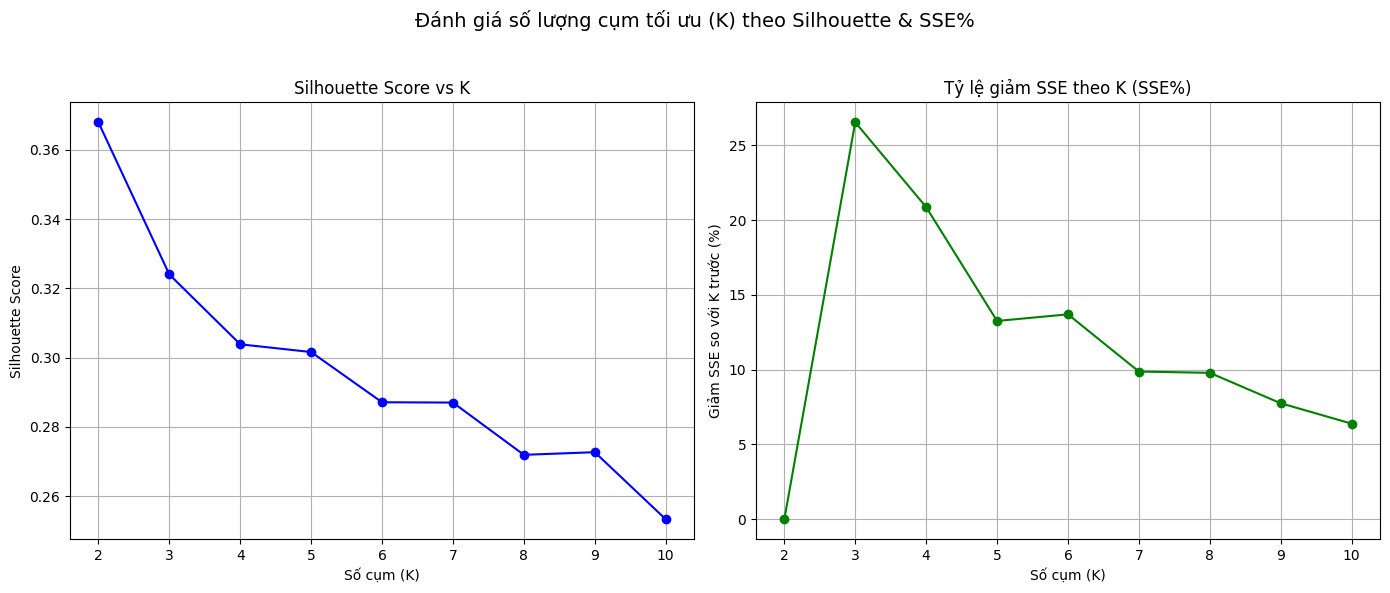

In [7]:
# Elbow Method để chọn k
X = rfm_df[['Scaled_Log_Recency', 'Scaled_Log_Frequency', 'Scaled_Log_Monetary']]

range_n_clusters = range(2, 11)
silhouette_avg_list = []
sse_list = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    
    # SSE
    sse = kmeans.inertia_
    sse_list.append(sse)

# Tính SSE%
sse_percent_drop = [0]  # Phần trăm giảm đầu tiên = 0
for i in range(1, len(sse_list)):
    drop = ((sse_list[i-1] - sse_list[i]) / sse_list[i-1]) * 100
    sse_percent_drop.append(drop)

# 🎨 Vẽ 2 biểu đồ cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Biểu đồ Silhouette
axes[0].plot(range_n_clusters, silhouette_avg_list, 'o-', color='blue')
axes[0].set_title('Silhouette Score vs K')
axes[0].set_xlabel('Số cụm (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True)
axes[0].set_xticks(range_n_clusters)

# Biểu đồ SSE%
axes[1].plot(range_n_clusters, sse_percent_drop, 'o-', color='green')
axes[1].set_title('Tỷ lệ giảm SSE theo K (SSE%)')
axes[1].set_xlabel('Số cụm (K)')
axes[1].set_ylabel('Giảm SSE so với K trước (%)')
axes[1].grid(True)
axes[1].set_xticks(range_n_clusters)

plt.suptitle('Đánh giá số lượng cụm tối ưu (K) theo Silhouette & SSE%', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
from sklearn.cluster import KMeans

# Lấy các cột đã chuẩn hóa từ rfm_df
df_now_scaled = rfm_df[['Scaled_Log_Recency', 'Scaled_Log_Frequency', 'Scaled_Log_Monetary']]

# Thực hiện phân cụm với k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_now_scaled)

# Gán nhãn phân cụm vào cột 'Cluster' trong rfm_df
rfm_df['Cluster'] = kmeans.labels_

# Xem kết quả
print(rfm_df.head())


   Unnamed: 0  Member_number  Recency  Frequency  Monetary  R  F  M  \
0        1388           2433        3          7    375.31  4  4  4   
1        1159           2193       91         11    361.45  3  4  4   
2         772           1793       26         10    345.10  4  4  4   
3        2225           3289        4         10    334.15  4  4  4   
4        1692           2743      142          7    312.46  2  4  4   

   RFM_Segment  RFM_Score       RFM_Level  Log_Recency  Log_Frequency  \
0          444         12  Best Customers     1.386294       2.079442   
1          344         11    Big Spenders     4.521789       2.484907   
2          444         12  Best Customers     3.295837       2.397895   
3          444         12  Best Customers     1.609438       2.397895   
4          244         10    Big Spenders     4.962845       2.079442   

   Log_Monetary  Scaled_Log_Recency  Scaled_Log_Frequency  \
0      5.930413           -2.262188              0.678072   
1      5.892

In [24]:
# Tính trung bình và đếm số lượng cho từng cụm
rfm_agg2 = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(0)

In [25]:
# Đổi tên cột
rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']

In [28]:
# Tính phần trăm
rfm_agg2['Percent'] = round((rfm_agg2['Count'] / rfm_agg2.Count.sum()) * 100, 2)
rfm_agg2 = rfm_agg2.reset_index()

# Tạo ánh xạ từ Cluster sang tên nhóm
cluster_to_group = {
    0: 'Loyal Customers', #Mua gần đây, tần suất ổn định, chi tiêu khá cao.
    1: 'At-Risk Customers', #Lâu không mua, tần suất thấp, chi tiêu không nổi bật.
    2: 'VIP', #Mua thường xuyên, chi tiêu cao, dù không phải gần đây nhất.
    3: 'Lost Customers' #Lâu không mua, hiếm khi mua, chi tiêu rất thấp.
}

# Tạo cột mới 'Kmeans_RFM'
rfm_agg2['Kmeans_RFM'] = rfm_agg2['Cluster'].map(cluster_to_group)

print(rfm_agg2)

   level_0  index  Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  \
0        0      0        0         20.0            4.0          95.0    644   
1        1      1        1        248.0            3.0          61.0   1455   
2        2      2        2        131.0            6.0         139.0   1230   
3        3      3        3        344.0            2.0          19.0    569   

   Percent         Kmeans_RFM  
0    16.52    Loyal Customers  
1    37.33  At-Risk Customers  
2    31.55                VIP  
3    14.60     Lost Customers  


In [29]:
import plotly.express as px
from plotly.offline import plot

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Kmeans_RFM",
                 hover_name="Kmeans_RFM", size_max=100)
plot(fig)

'temp-plot.html'

![](RFM_Kmeans.png)

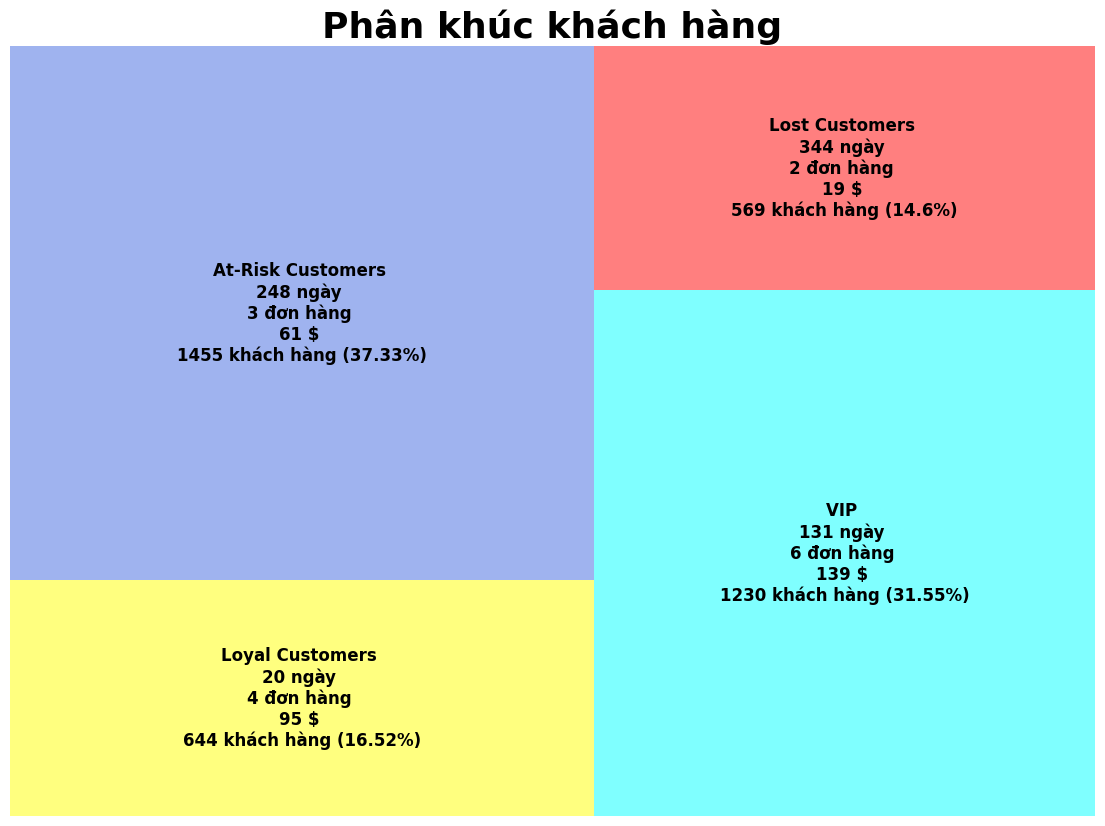

In [32]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)
colors_dict2 = {'Loyal Customers':'yellow','At-Risk Customers':'royalblue', 'VIP':'cyan',
               'Lost Customers':'red'}
# Vẽ treemap
squarify.plot(
    sizes=rfm_agg2['Count'],
    color=[colors_dict2[group] for group in rfm_agg2['Kmeans_RFM']],  # Lấy màu dựa trên Kmeans_RFM
    label=['{} \n{:.0f} ngày \n{:.0f} đơn hàng \n{:.0f} $ \n{:.0f} khách hàng ({}%)'.format(
        rfm_agg2['Kmeans_RFM'][i],  # Sử dụng tên nhóm từ Kmeans_RFM
        rfm_agg2['RecencyMean'][i],
        rfm_agg2['FrequencyMean'][i],
        rfm_agg2['MonetaryMean'][i],
        rfm_agg2['Count'][i],
        rfm_agg2['Percent'][i]
    ) for i in range(len(rfm_agg2))],
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    alpha=0.5
)

# Tiêu đề và hiển thị
plt.title("Phân khúc khách hàng", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

##### Cluster 0 (Màu vàng): Recency rất thấp (20), chi tiêu tốt (95), mua đều (4 orders) → Khách mới quay lại và tiềm năng => New Customers
##### Cluster 1 (Màu xanh lam): Recency cao (248), mua ít, chi tiêu trung bình → Không tương tác gần đây, có dấu hiệu rời bỏ => At-Risk/Occasional
##### Cluster 2 (Màu xanh lục): ĐR vừa (131), mua nhiều (6), chi tiêu cao (139) → Tương tác mạnh và giá trị cao => Best Customers
##### Cluster 3 (Màu đỏ): R cực cao (344), ít mua, chi tiêu thấp → Gần như đã rời bỏ => Lost Customers

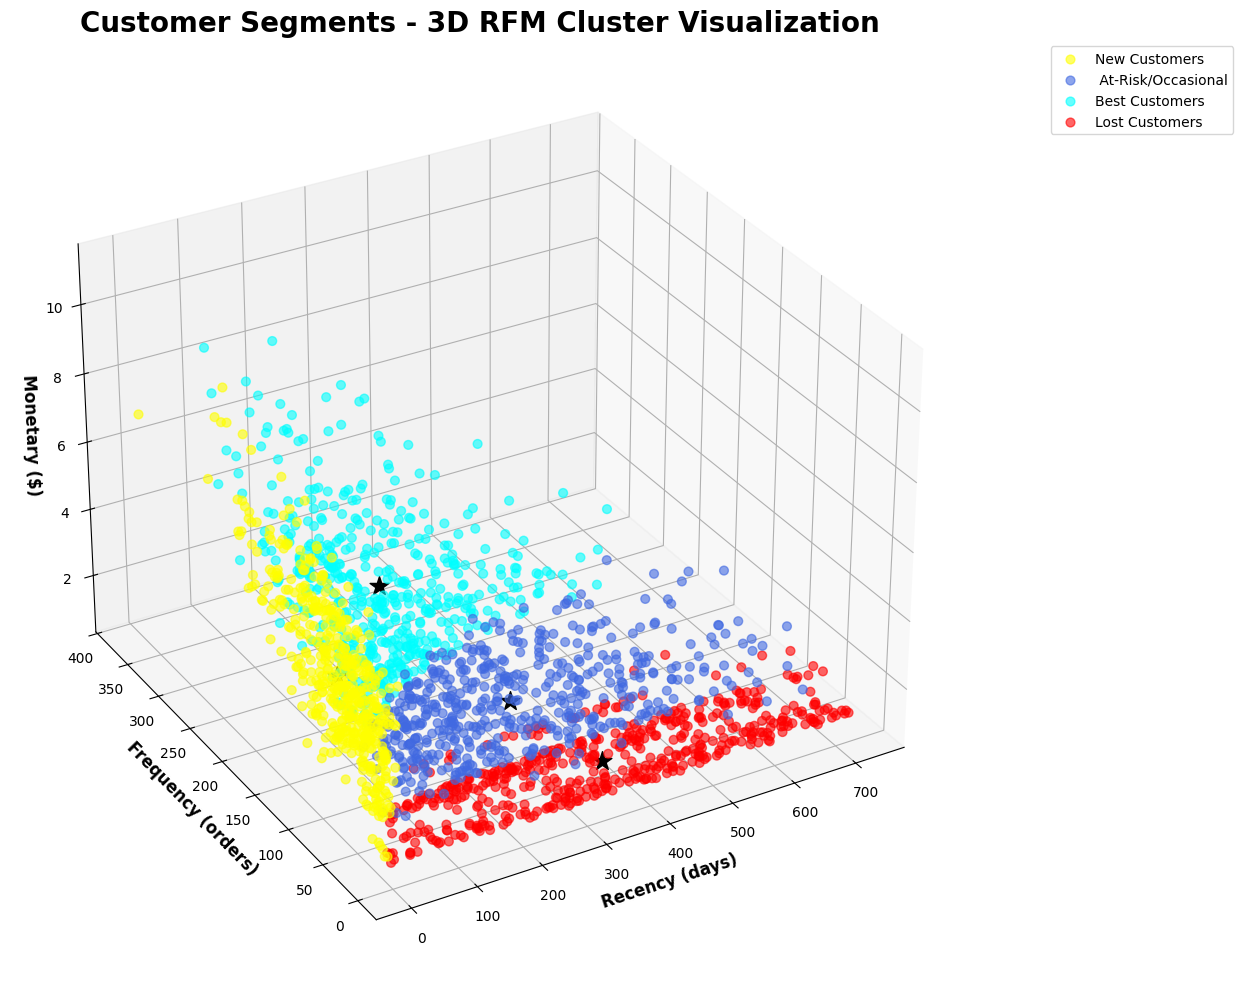

In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Giả sử bạn đã có pandas DataFrame với dữ liệu RFM và nhãn cụm từ scikit-learn
# DataFrame này có thể có dạng như sau:
# rfm_df với các cột: 'Recency', 'Frequency', 'Monetary', 'Cluster'
lst_customer_group = ['New Customers',' At-Risk/Occasional','Best Customers','Lost Customers']
# Tính toán thống kê cho mỗi cụm
cluster_stats = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).reset_index()

# Tính phần trăm
total_customers = cluster_stats['Count'].sum()
cluster_stats['Percentage'] = (cluster_stats['Count'] / total_customers * 100).round(2)

# Màu sắc cho các cụm - giữ nhất quán với biểu đồ treemap của bạn
colors_dict = {
    0: 'yellow', 
    1: 'royalblue', 
    2: 'cyan',
    3: 'red', 
    4: 'purple', 
    5: 'green', 
    6: 'gold'
}

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Vẽ điểm cho mỗi cụm
for cluster in sorted(rfm_df['Cluster'].unique()):
    # Lọc dữ liệu cho cụm hiện tại
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster]
    
    # Lấy mẫu nếu dữ liệu quá lớn (để tránh biểu đồ quá tải)
    if len(cluster_data) > 500:
        cluster_data = cluster_data.sample(n=500, random_state=42)
    
    # Vẽ các điểm dữ liệu
    color = colors_dict.get(cluster, 'gray')
    ax.scatter(
        cluster_data['Recency'],
        cluster_data['Monetary'],
        cluster_data['Frequency'],
        c=color,
        s=40,
        alpha=0.6,
        label=f'{lst_customer_group[cluster]}'
    )
    
    # Vẽ centroid với kích thước lớn hơn
    centroid = cluster_stats[cluster_stats['Cluster'] == cluster]
    ax.scatter(
        centroid['Recency'],
        centroid['Monetary'],
        centroid['Frequency'],
        c='black',
        s=200,
        alpha=1.0,
        marker='*',
        edgecolors='black'
    )
    
    # # Thêm nhãn cho centroid
    # ax.text(
    #     centroid['Recency'].values[0],
    #     centroid['Monetary'].values[0],
    #     centroid['Frequency'].values[0],
    #     f'Cluster {cluster}\n{centroid["Recency"].values[0]:.0f} days\n{centroid["Frequency"].values[0]:.0f} orders\n{centroid["Monetary"].values[0]:.0f} $\n{centroid["Count"].values[0]} customers ({centroid["Percentage"].values[0]}%)',
    #     fontsize=10,
    #     color='black',
    #     fontweight='bold',
    #     ha='center'
    # )

# Chỉnh sửa biểu đồ
ax.set_xlabel('Recency (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (orders)', fontsize=12, fontweight='bold')
ax.set_zlabel('Monetary ($)', fontsize=12, fontweight='bold')
ax.set_title('Customer Segments - 3D RFM Cluster Visualization', fontsize=20, fontweight='bold')

# Thêm lưới để dễ đọc
ax.grid(True)

# Thêm chú thích
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0))

# Tối ưu hóa góc nhìn
ax.view_init(elev=30, azim=240)
plt.tight_layout()
plt.show()

In [33]:
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import numpy as np
import joblib

In [34]:
# Bước 1: Hàm log1p
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Bước 2: RobustScaler
scaler = RobustScaler()

# Bước 3: Mô hình phân cụm KMeans
kmeans = KMeans(n_clusters=4, random_state=42)

# Gộp pipeline
pipeline = Pipeline(steps=[
    ('log1p', log_transformer),
    ('scaler', scaler),
    ('kmeans', kmeans)
])

In [35]:
pipeline.fit(df_now)

Pipeline(steps=[('log1p',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scaler', RobustScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [36]:
joblib.dump(pipeline, 'customer_segmentation_pipeline.pkl')

['customer_segmentation_pipeline.pkl']

In [37]:
df = pd.DataFrame({'Recency':[91],'Frequency':[11],'Monetary':[361.31]})

In [38]:
df

,Recency,Frequency,Monetary
0,91,11,361.31


In [39]:
# Load lại pipeline
pipeline = joblib.load('customer_segmentation_pipeline.pkl')

# Dự đoán cho dữ liệu mới
cluster = pipeline.predict(df)
print(f'Phân cụm: Cluster {cluster[0]}')


Phân cụm: Cluster 2
